# Concentration Data Augmentation
Before we move on with PINN, we already extracted data from a refinery plant. This plant has a reactor unit that perform desulfurization process to remove sulfur from the feed. Since we have a sample point from the feed and the outlet reactor, we have the sulfur concentration dataset for certain period of times.

The issues here is that, the data is limited. We have less than 20 points of data and we need to augment this first before we move on with our PINN trial. So this notebook functions as the data augmentation script for our concentration dataset. Few assumptions need to be established before we proceed.

1. The reactor has LHSV of $1h^{-1}$. This means that the concentration data that we has shows the reduction in sulfur concentration in 1 hr
2. The unit of concentration is wt%. 
3. The data consists of 3 operating modes, each with different quality of feedstocks.

In [2]:
#first let's load and view the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('Conc_database.xlsx',sheet_name = 'Combine')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sulfur  13 non-null     object 
 1   T1      13 non-null     float64
 2   T2      13 non-null     float64
dtypes: float64(2), object(1)
memory usage: 444.0+ bytes


In [3]:
#let's display the entirety of data
df

,Sulfur,T1,T2
0,S1,0.0621,0.0001
1,S2,0.0692,0.0001
2,S3,0.0698,0.0001
3,S4,0.0989,0.0004
4,S5,0.0943,0.0004
5,S6,0.0931,0.0003
6,S7,0.0552,0.0004
7,S8,0.0561,0.0001
8,S9,0.0480,0.0001
9,S10,0.0517,0.0001


In [4]:
#let's do some preprocessing first, since we don't need that sulfur column
df = df.drop(['Sulfur'],axis=1)
df

,T1,T2
0,0.0621,0.0001
1,0.0692,0.0001
2,0.0698,0.0001
3,0.0989,0.0004
4,0.0943,0.0004
5,0.0931,0.0003
6,0.0552,0.0004
7,0.0561,0.0001
8,0.0480,0.0001
9,0.0517,0.0001


## Let's plot the distribution of this data
The data is now ready. It is in the correct data type, has no missing values and fully functional. Before we perform any augmentation, let's first understand the data. We need to look at the distribution of the data to figure out which is the best augmentation methods to use. 

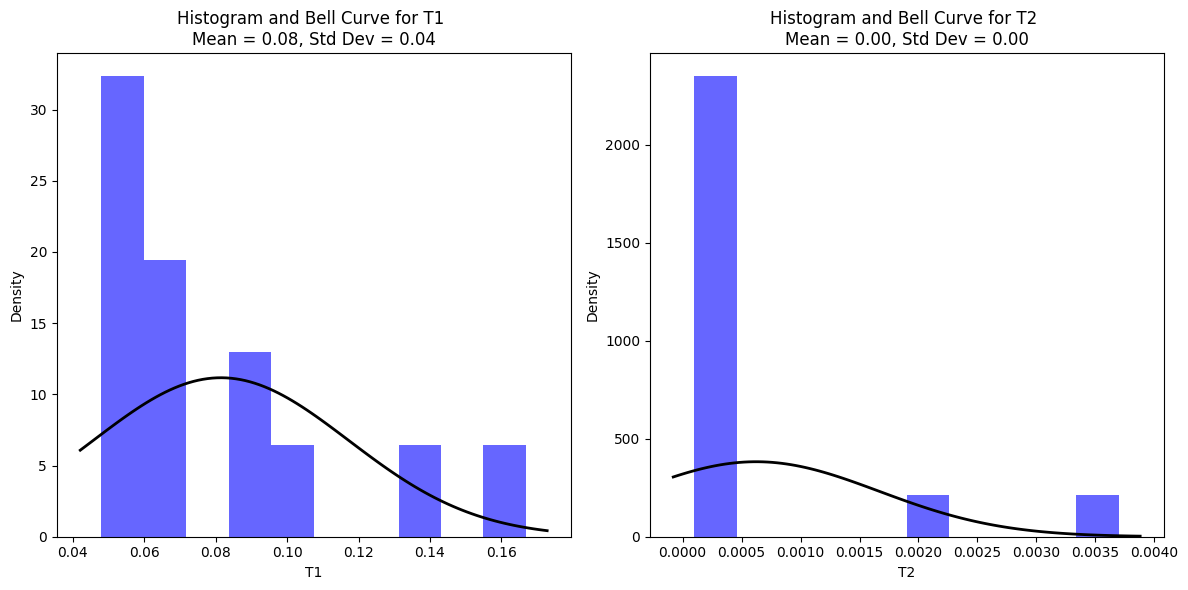

In [9]:
from scipy.stats import norm

# Function to plot histogram and bell curve
def plot_hist_with_bell_curve(data, column_name):
    # Plot histogram
    plt.hist(data, bins=10, density=True, alpha=0.6, color='blue')

    # Fit a normal distribution and get the mean and standard deviation
    mu, std = norm.fit(data)

    # Plot the bell curve (normal distribution curve)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    # Titles and labels
    title = f'Histogram and Bell Curve for {column_name} \nMean = {mu:.2f}, Std Dev = {std:.2f}'
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Density')

# Create the plots for both columns
plt.figure(figsize=(12, 6))

# Column 1
plt.subplot(1, 2, 1)
plot_hist_with_bell_curve(df['T1'], 'T1')

# Column 2
plt.subplot(1, 2, 2)
plot_hist_with_bell_curve(df['T2'], 'T2')

plt.tight_layout()
plt.show()



From the data above, we can see that our data is mostly in normal distrivution plot with very few anomalies. The data itself is logical from the standpoint of chemical engineers as higher concentration at T1 will see higher concentraton at T2. Therefore, we can do data augmentation through standard deviation method, but we will do it iteratively row by row

In [10]:
import numpy as np
import pandas as pd

# Augmentation based on standard deviation
def augment_with_std(df, num_points):
    # Step 1: Compute the standard deviation and mean of each column
    stds = df.std()
    means = df.mean()
    
    # Step 2: Interpolate data points
    x = np.linspace(0, len(df) - 1, num=len(df))  # Original indices
    new_x = np.linspace(0, len(df) - 1, num=num_points)  # New indices for interpolation

    augmented_df = pd.DataFrame({
        'T1': np.interp(new_x, x, df['T1']),
        'T2': np.interp(new_x, x, df['T2'])
    })
    
    # Step 3: Apply a controlled shift based on standard deviation
    for col in augmented_df.columns:
        shift = stds[col] * (np.random.uniform(-1, 1, size=len(augmented_df)) * 0.1)
        augmented_df[col] = augmented_df[col] + shift
    
    return augmented_df

# Augment the dataset to 100 points
augmented_df = augment_with_std(df, 100)
augmented_df


,T1,T2
0,0.060396,0.000146
1,0.063786,0.000060
2,0.062366,0.000197
3,0.065536,0.000138
4,0.063009,0.000082
...,...,...
95,0.092855,0.001819
96,0.081355,0.001499
97,0.070722,0.001028
98,0.059330,0.000457


Alright, our augmentation is now complete. But let's verify it first, let's plot our data distribution through histogram and bell curve

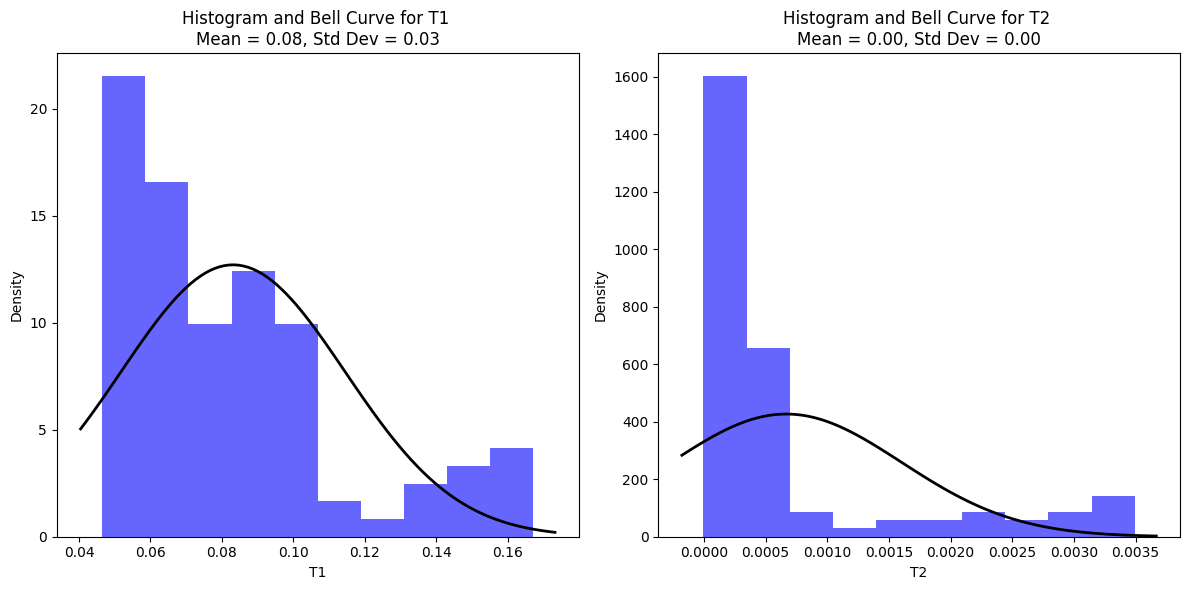

In [11]:
from scipy.stats import norm

# Function to plot histogram and bell curve
def plot_hist_with_bell_curve(data, column_name):
    # Plot histogram
    plt.hist(data, bins=10, density=True, alpha=0.6, color='blue')

    # Fit a normal distribution and get the mean and standard deviation
    mu, std = norm.fit(data)

    # Plot the bell curve (normal distribution curve)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    
    # Titles and labels
    title = f'Histogram and Bell Curve for {column_name} \nMean = {mu:.2f}, Std Dev = {std:.2f}'
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Density')

# Create the plots for both columns
plt.figure(figsize=(12, 6))

# Column 1
plt.subplot(1, 2, 1)
plot_hist_with_bell_curve(augmented_df['T1'], 'T1')

# Column 2
plt.subplot(1, 2, 2)
plot_hist_with_bell_curve(augmented_df['T2'], 'T2')

plt.tight_layout()
plt.show()

Alright, it seems like our data augmentation works and it still matches our original distribution. It means that we can use this data although it is synthetic data. 

In [12]:
augmented_df.to_csv('concentration.csv',index=False)